Лабораторная работа 1. Рекомендательные системы

Цель работы: формирование практических навыков проектирования и реализации базовой рекомендательной системы с использованием методов машинного и глубокого обучения.

Выбранный датасет: Customer Rating Data By Amazon (Данные о Рейтинге клиентов Amazon)

Описание датасета: набор данных содержит коллекцию из более чем 1 миллиона отзывов покупателей и рейтингов косметических товаров, доступных на платформе Amazon. 

Столбцы в датасете: <br/>
user_id - уникальный идентификатор пользователя<br/>
item_id - уникальный идентификатор товара<br/>
rating - рейтинг, который отражает удовлетворенность клиентов по шкале от 1 до 5<br/>
timestamp - временная метка, записанная в UNIX формате, указывает, когда была представлена оценка<br/>

1. Загрузка датасета и первичный анализ данных

Размер датасета: (1048575, 4)
Статистика:
             rating     timestamp
count  1.048575e+06  1.048575e+06
mean   4.176864e+00  1.345636e+09
std    1.306543e+00  5.567113e+07
min    1.000000e+00  9.087552e+08
25%    4.000000e+00  1.322438e+09
50%    5.000000e+00  1.362960e+09
75%    5.000000e+00  1.385856e+09
max    5.000000e+00  1.406074e+09
Пропуски:
user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64


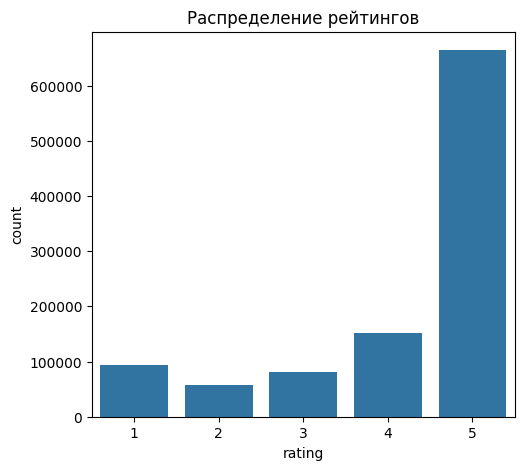

<Figure size 1400x800 with 0 Axes>

Уникальных пользователей: 736653
Уникальных объектов: 97987


In [79]:
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv('customer_ratings_data.csv')

print(f"Размер датасета: {df.shape}")
print(f"Статистика:\n{df.describe()}")

print(f"Пропуски:\n{df.isnull().sum()}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='rating', data=df)
plt.title('Распределение рейтингов')
plt.figure(figsize=(14, 8))
plt.tight_layout()
plt.show()

print(f"Уникальных пользователей: {df['user_id'].nunique()}")
print(f"Уникальных объектов: {df['item_id'].nunique()}")

Судя по диаграмме распределения рейтингов, большинство товаров имеет рейтинг 5. 

2. Отбор 10000 записей 

Исходное количество записей: 1,048,575
Количество записей после фильтрации: 139,228
Уникальных пользователей до фильтрации: 736,653
Уникальных пользователей после фильтрации: 17,552

Распределение взаимодействий после фильтрации:
count    17552.000000
mean         7.932315
std          6.946279
min          5.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        278.000000
Name: count, dtype: float64
После фильтрации: 122021 взаимодействий
Уникальных пользователей: 17518
Уникальных объектов: 25325

Дополнительное сокращение до 10,000 записей
Попытка 1: пользователей=100, объектов=100 -> 345 записей
Попытка 2: пользователей=120, объектов=120 -> 461 записей
Попытка 3: пользователей=144, объектов=144 -> 611 записей
Попытка 4: пользователей=172, объектов=172 -> 782 записей
Попытка 5: пользователей=206, объектов=206 -> 1013 записей
Попытка 6: пользователей=247, объектов=247 -> 1316 записей
Попытка 7: пользователей=296, объектов=296 -> 1663 записей
Попытка 8: по

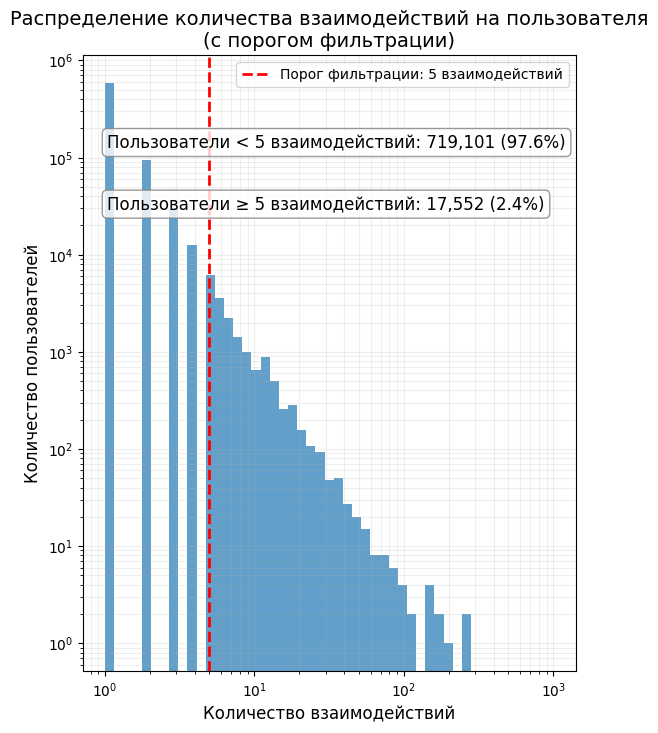

In [80]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
user_interactions = df['user_id'].value_counts()
plt.hist(user_interactions, bins=np.logspace(0, 3, 50), alpha=0.7, color='#1f77b4')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.axvline(x=5, color='red', linestyle='--', linewidth=2, label='Порог фильтрации: 5 взаимодействий')

total_users = len(user_interactions)
users_below_threshold = (user_interactions < 5).sum()
users_above_threshold = (user_interactions >= 5).sum()

plt.annotate(f'Пользователи < 5 взаимодействий: {users_below_threshold:,} ({users_below_threshold/total_users:.1%})', 
             xy=(0.05, 0.85), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.annotate(f'Пользователи ≥ 5 взаимодействий: {users_above_threshold:,} ({users_above_threshold/total_users:.1%})', 
             xy=(0.05, 0.75), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.title('Распределение количества взаимодействий на пользователя\n(с порогом фильтрации)', fontsize=14)
plt.xlabel('Количество взаимодействий', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.legend()

user_interactions = df['user_id'].value_counts()
min_interactions = 5
valid_users = user_interactions[user_interactions >= min_interactions].index
filtered_df = df[df['user_id'].isin(valid_users)]

print(f"Исходное количество записей: {len(df):,}")
print(f"Количество записей после фильтрации: {len(filtered_df):,}")
print(f"Уникальных пользователей до фильтрации: {df['user_id'].nunique():,}")
print(f"Уникальных пользователей после фильтрации: {filtered_df['user_id'].nunique():,}")

print("\nРаспределение взаимодействий после фильтрации:")
print(filtered_df['user_id'].value_counts().describe())


df = df.drop_duplicates(subset=['user_id', 'item_id'])
min_interactions = 5
user_counts = df['user_id'].value_counts()
item_counts = df['item_id'].value_counts()
valid_users = user_counts[user_counts >= min_interactions].index
valid_items = item_counts[item_counts >= min_interactions].index
df = df[df['user_id'].isin(valid_users) & df['item_id'].isin(valid_items)]

user_ids = df['user_id'].unique()
item_ids = df['item_id'].unique()

user2idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
item2idx = {item_id: idx for idx, item_id in enumerate(item_ids)}

df['user_idx'] = df['user_id'].map(user2idx)
df['item_idx'] = df['item_id'].map(item2idx)


print(f"После фильтрации: {df.shape[0]} взаимодействий")
print(f"Уникальных пользователей: {df['user_idx'].nunique()}")
print(f"Уникальных объектов: {df['item_idx'].nunique()}")


print("\n" + "="*50)
print("Дополнительное сокращение до 10,000 записей")

user_interactions = df['user_id'].value_counts()
def find_optimal_subset(df, target_size=10000, max_attempts=20):
    """Автоматически подбирает количество пользователей и объектов для достижения целевого размера"""
    user_counts = df['user_id'].value_counts()
    item_counts = df['item_id'].value_counts()
    
    user_cutoff = max(100, int(np.sqrt(target_size)))
    item_cutoff = max(100, int(np.sqrt(target_size)))
    
    for attempt in range(max_attempts):
        top_users = user_counts.head(user_cutoff).index
        top_items = item_counts.head(item_cutoff).index
        
        subset = df[df['user_id'].isin(top_users) & df['item_id'].isin(top_items)].copy()
        
        current_size = len(subset)
        
        print(f"Попытка {attempt+1}: пользователей={user_cutoff}, объектов={item_cutoff} -> {current_size} записей")
        
        if abs(current_size - target_size) < 0.1 * target_size:
            return subset, user_cutoff, item_cutoff
        
        if current_size < target_size * 0.8:
            user_cutoff = int(user_cutoff * 1.2)
            item_cutoff = int(item_cutoff * 1.2)
        elif current_size > target_size * 1.2:
            user_cutoff = max(50, int(user_cutoff * 0.8))
            item_cutoff = max(50, int(item_cutoff * 0.8))
    
    if len(subset) > target_size:
        subset = subset.sample(target_size, random_state=42)
    
    return subset, user_cutoff, item_cutoff

final_df, selected_users, selected_items = find_optimal_subset(df, target_size=10000)

print(f"\nОкончательный размер: {len(final_df)} взаимодействий")
print(f"Использовано: {selected_users} пользователей (из {df['user_id'].nunique()})")
print(f"Использовано: {selected_items} объектов (из {df['item_id'].nunique()})")


user_ids = final_df['user_id'].unique()
item_ids = final_df['item_id'].unique()

user2idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
item2idx = {item_id: idx for idx, item_id in enumerate(item_ids)}

final_df['user_idx'] = final_df['user_id'].map(user2idx)
final_df['item_idx'] = final_df['item_id'].map(item2idx)


df = final_df  
n_users = df['user_idx'].nunique()
n_items = df['item_idx'].nunique()

В качестве условия фильтрации пользователей было выбрано число его взаимодействий (сколько раз пользователь оценивал различные товары).

На диаграмме распределения количества взаимодействий на пользователя при выбранном условии фильтрации видно, что всего лишь 2.4% пользователей (17 552 человек) имеют 5 и более взаимодействий. После фильтрации количество записей резко сократилось (139 228).

Для дальнейшего отбора до 10000 записей были выполнены следующие шаги:<br/>
1. Определение активных пользователей. 
Подсчет количества взаимодействий для каждого пользователя в датасете
2. Инициализация параметров поиска. 
Установка начальных значений user_cutoff и item_cutoff как ~100 (квадратный корень от целевого размера)
3. Итеративный поиск оптимальных размеров <br/>
    3.1 Выбор топ-N пользователей и топ-N объектов<br/>
    3.2 Формирование подмножества данных<br/>
    3.3 Проверка размера полученного подмножества<br/>
4. Адаптивная корректировка. 
Увеличение размеров, если подмножество слишком маленькое, уменьшение размеров, если подмножество слишком большое.
Поиск прекращается при достижении целевого размера (±10%).
5. Финальная обработка. 
Возврат итогового подмножества и использованных размеров

В результате отбора было достигнуто 9616 записей.

3. Базовая модель - определение и обучение

Рекомендуемая размерность эмбеддингов: 32
Epoch 1, Loss: 2.055546810765484
Epoch 1, Train Loss: 2.0555, Val Loss: 1.6745, Train RMSE: 1.4344, Val RMSE: 1.2975
Epoch 2, Loss: 1.320969579007121
Epoch 2, Train Loss: 1.3210, Val Loss: 1.6013, Train RMSE: 1.1502, Val RMSE: 1.2703
Epoch 3, Loss: 1.0924274983247781
Epoch 3, Train Loss: 1.0924, Val Loss: 1.6981, Train RMSE: 1.0449, Val RMSE: 1.3074
Epoch 4, Loss: 0.9222494947465129
Epoch 4, Train Loss: 0.9222, Val Loss: 1.5566, Train RMSE: 0.9605, Val RMSE: 1.2531
Epoch 5, Loss: 0.776957728679744
Epoch 5, Train Loss: 0.7770, Val Loss: 1.6576, Train RMSE: 0.8820, Val RMSE: 1.2950
Epoch 6, Loss: 0.6693616372173753
Epoch 6, Train Loss: 0.6694, Val Loss: 1.8762, Train RMSE: 0.8175, Val RMSE: 1.3793
Epoch 7, Loss: 0.537051436750226
Epoch 7, Train Loss: 0.5371, Val Loss: 1.7254, Train RMSE: 0.7328, Val RMSE: 1.3197
Epoch 8, Loss: 0.4241161569643812
Epoch 8, Train Loss: 0.4241, Val Loss: 1.7666, Train RMSE: 0.6514, Val RMSE: 1.3364
Epoch 9, Loss: 0.3

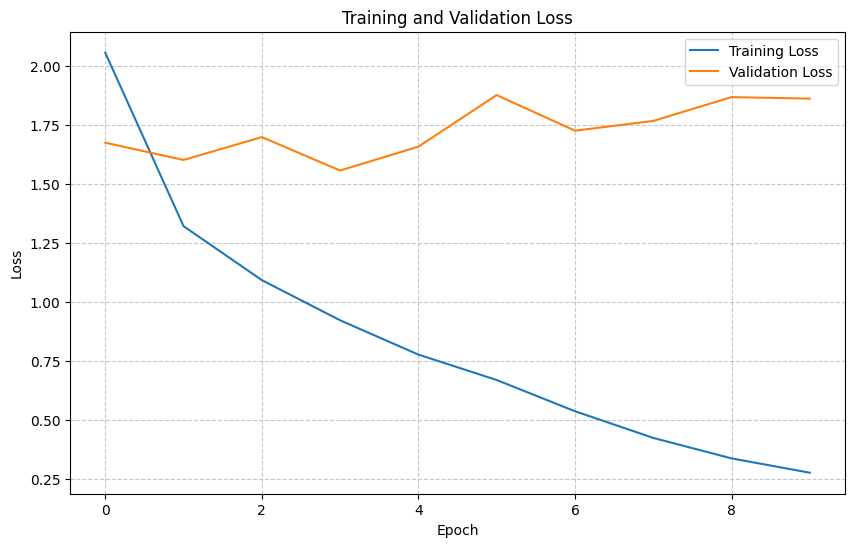

In [81]:
def get_optimal_embedding_dim(n_users, n_items):
    """Вычисляет рекомендуемую размерность эмбеддингов"""
    calculated_dim = int(1.6 * np.sqrt(n_items) + 1.2 * np.sqrt(n_users))
    return max(8, min(32, calculated_dim))

n_users = df['user_idx'].nunique()
n_items = df['item_idx'].nunique()
optimal_dim = get_optimal_embedding_dim(n_users, n_items)
print(f"Рекомендуемая размерность эмбеддингов: {optimal_dim}")

class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_idx'].values, dtype=torch.long)
        self.items = torch.tensor(df['item_idx'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]
    
class RecommenderNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=optimal_dim):
        super(RecommenderNN, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)

        x = torch.cat([user_emb, item_emb], dim=1)

        return self.fc_layers(x).squeeze()

dataset = RatingsDataset(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

base_model = RecommenderNN(n_users, n_items).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.005)

train_losses_base = []  
val_losses_base = []

for epoch in range(10):
    base_model.train()
    total_loss = 0
    all_predictions = []
    all_ratings = []
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        optimizer.zero_grad()
        predictions = base_model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_predictions.extend(predictions.cpu().detach().numpy())
        all_ratings.extend(ratings.cpu().detach().numpy())

    rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    mae = mean_absolute_error(all_ratings, all_predictions)

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

    train_rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    train_mae = mean_absolute_error(all_ratings, all_predictions)
    
    train_losses_base.append(total_loss/len(train_loader))
    
    base_model.eval()
    val_loss = 0
    val_predictions = []
    val_ratings = []
    
    with torch.no_grad():
        for users, items, ratings in test_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            predictions = base_model(users, items)
            val_loss += criterion(predictions, ratings).item()
            
            val_predictions.extend(predictions.cpu().numpy())
            val_ratings.extend(ratings.cpu().numpy())
    
    val_rmse = math.sqrt(mean_squared_error(val_ratings, val_predictions))
    val_mae = mean_absolute_error(val_ratings, val_predictions)
    val_losses_base.append(val_loss/len(test_loader))
    
    print(f'Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss/len(test_loader):.4f}, '
          f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(train_losses_base, label='Training Loss')
plt.plot(val_losses_base, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

В полученных данных наблюдается  переобучение: тренировочная ошибка последовательно снижается, валидационная ошибка начинает расти после 3-4 эпох. К 10 эпохе  валидационная ошибка стала значительно выше тренировочной. Train RMSE уменьшается(модель "запоминает" тренировочные данные). Val RMSE сначала немного снижается, затем резко растет. Расхождение между Train и Val RMSE увеличивается с каждой эпохой.

4. Базовая модель - оценка и рекомендации

In [82]:
base_model.eval()
test_predictions = []
test_ratings = []
with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = base_model(users, items)
        test_predictions.extend(predictions.cpu().numpy())
        test_ratings.extend(ratings.cpu().numpy())

test_rmse_base = math.sqrt(mean_squared_error(test_ratings, test_predictions))
test_mae_base = mean_absolute_error(test_ratings, test_predictions)

print(f'\nTest RMSE: {test_rmse_base:.4f}, Test MAE: {test_mae_base:.4f}')

idx2user = {v: k for k, v in user2idx.items()}
idx2item = {v: k for k, v in item2idx.items()}

random_user_ids = np.random.choice(df['user_id'].unique(), size=5)

print("\nRecommendations for random users:")
for user_id in random_user_ids:
    if user_id not in user2idx:
        continue
    user_idx = user2idx[user_id]
    
    user_history = df[df['user_id'] == user_id]['item_id'].values
    user_history_idx = [item2idx[item] for item in user_history if item in item2idx]
    
    all_items_idx = set(range(n_items))
    candidate_items_idx = list(all_items_idx - set(user_history_idx))
    
    if not candidate_items_idx:
        print(f"User {user_id}: Нет кандидатов для рекомендации")
        continue
    
    user_tensor = torch.tensor([user_idx] * len(candidate_items_idx), dtype=torch.long).to(device)
    item_tensor = torch.tensor(candidate_items_idx, dtype=torch.long).to(device)
    
    with torch.no_grad():
        predictions = base_model(user_tensor, item_tensor).cpu().numpy()
    
    top_indices = np.argsort(predictions)[::-1][:5]
    top_items_idx = [candidate_items_idx[i] for i in top_indices]
    top_items = [idx2item[idx] for idx in top_items_idx]
    
    print(f"User {user_id}: Recommended items {top_items}")


Test RMSE: 1.3720, Test MAE: 1.0811

Recommendations for random users:
User AKFN06SRM2ZZR: Recommended items ['B0036I8BPE', 'B00157DO4Q', 'B0009OAGXI', 'B001ET77NY', 'B000V2DLJO']
User A2L4LUQCMWBFVO: Recommended items ['B00008O2X5', 'B000V5BXNM', 'B00022WA9K', 'B003E3IOPS', 'B0018OWHQM']
User A3KBL59PYXZQPZ: Recommended items ['B000V1BDIG', 'B0012BNVE8', 'B0017SWIU4', 'B000TZJVBK', 'B000PY17PI']
User A2KJQX0MK4E8GY: Recommended items ['B002TPO0W8', 'B000FGDIAS', 'B0017SWIU4', 'B001ET77NY', 'B002TLT388']
User A36WGHR8TO5DKT: Recommended items ['B000PHUKEE', 'B00008O2X5', 'B003GVCU62', 'B000F35R00', 'B002X9XV48']


В результате получаем довольно высокие значения RMSE и MAE.

5. Улучшенная модель - определение и обучение

Были проведены следующие изменения:
- Добавлены bias-эмбеддинги. Они позволяют модели учитывать систематические смещения (некоторые пользователи всегда ставят высокие оценки, некоторые объекты обычно получают низкие оценки)
- Добавлены dropout-слои. Они помогают бороться с переобучением на небольшом датасете (10к записей)
- Калибровка смещений в forward-проходе
- Уменьшение скорости обучения, что позволяет модели точнее находить минимум
- Добавление L1-регуляризации в процесс обучения помогает создать более разреженные эмбеддинги
- Добавление L2-регуляризации уменьшает сложность модели и борется с переобучением
- Градиентный клиппинг предотвращает "взрыв" градиентов и делает обучение более стабильным
- ReduceLROnPlateau scheduler автоматически уменьшает скорость обучения при стагнации
- Ранняя остановка сохраняет лучшую версию модели и предотвращает переобучение

Epoch 1, Loss: 3.287910929359341
Epoch 1, Train Loss: 3.2879, Val Loss: 1.5682, Train RMSE: 1.8141, Val RMSE: 1.2507
  -> Сохранена новая лучшая модель
Epoch 2, Loss: 1.6199354111406319
Epoch 2, Train Loss: 1.6199, Val Loss: 1.5092, Train RMSE: 1.2709, Val RMSE: 1.2265
  -> Сохранена новая лучшая модель
Epoch 3, Loss: 1.4820241341947025
Epoch 3, Train Loss: 1.4820, Val Loss: 1.5554, Train RMSE: 1.2173, Val RMSE: 1.2444
  -> Терпение: 1/5
Epoch 4, Loss: 1.3682919908855962
Epoch 4, Train Loss: 1.3683, Val Loss: 1.5046, Train RMSE: 1.1699, Val RMSE: 1.2253
  -> Сохранена новая лучшая модель
Epoch 5, Loss: 1.2989073243625926
Epoch 5, Train Loss: 1.2989, Val Loss: 1.4701, Train RMSE: 1.1389, Val RMSE: 1.2108
  -> Сохранена новая лучшая модель
Epoch 6, Loss: 1.219974328868122
Epoch 6, Train Loss: 1.2200, Val Loss: 1.5048, Train RMSE: 1.1039, Val RMSE: 1.2224
  -> Терпение: 1/5
Epoch 7, Loss: 1.1715014459433892
Epoch 7, Train Loss: 1.1715, Val Loss: 1.4635, Train RMSE: 1.0818, Val RMSE: 1.205

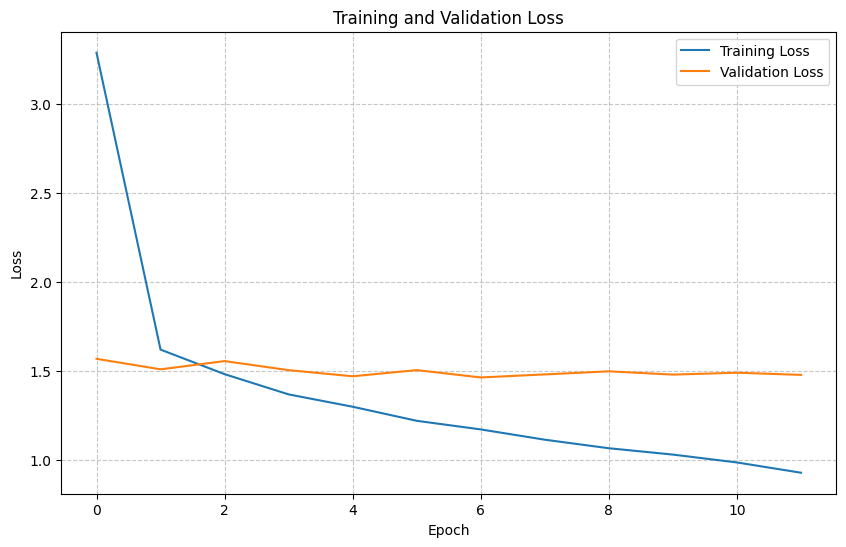

In [83]:
class RatingsDatasetImprove(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_idx'].values, dtype=torch.long)
        self.items = torch.tensor(df['item_idx'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]
    
class RecommenderNNImprove(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=optimal_dim):
        super(RecommenderNNImprove, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        
        user_bias = self.user_bias(user).squeeze()
        item_bias = self.item_bias(item).squeeze()
        
        x = torch.cat([user_emb, item_emb], dim=1)
        
        output = self.fc_layers(x).squeeze()
        
        return output + user_bias + item_bias
    

dataset = RatingsDatasetImprove(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

improved_model = RecommenderNNImprove(n_users, n_items).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001, weight_decay=1e-5, betas=(0.9, 0.995))

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6
)

num_epochs = 25
best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses_improved = []  
val_losses_improved = []

for epoch in range(num_epochs):
    improved_model.train()
    total_loss = 0
    all_predictions = []
    all_ratings = []
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        optimizer.zero_grad()
        predictions = improved_model(users, items)
        loss = criterion(predictions, ratings)

        l1_lambda = 1e-6
        l1_norm = sum(torch.linalg.norm(p, 1) for p in improved_model.parameters())
        loss = loss + l1_lambda * l1_norm

        loss.backward()
        torch.nn.utils.clip_grad_norm_(improved_model.parameters(), 1.0)  
        optimizer.step()
        total_loss += loss.item()

        all_predictions.extend(predictions.cpu().detach().numpy())
        all_ratings.extend(ratings.cpu().detach().numpy())

    rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    mae = mean_absolute_error(all_ratings, all_predictions)
    train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {train_loss}')

    train_rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    train_mae = mean_absolute_error(all_ratings, all_predictions)
    
    train_losses_improved.append(total_loss/len(train_loader))
    
    improved_model.eval()
    val_loss = 0
    val_predictions = []
    val_ratings = []
    
    with torch.no_grad():
        for users, items, ratings in test_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            predictions = improved_model(users, items)
            val_loss += criterion(predictions, ratings).item()
            
            val_predictions.extend(predictions.cpu().numpy())
            val_ratings.extend(ratings.cpu().numpy())
    
    val_rmse = math.sqrt(mean_squared_error(val_ratings, val_predictions))
    val_mae = mean_absolute_error(val_ratings, val_predictions)
    val_losses_improved.append(val_loss/len(test_loader))
    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss/len(test_loader):.4f}, '
          f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(improved_model.state_dict(), 'best_model.pth')
        patience_counter = 0
        print("  -> Сохранена новая лучшая модель")
    else:
        patience_counter += 1
        print(f"  -> Терпение: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"\nРанняя остановка на эпохе {epoch+1}")
            break

plt.figure(figsize=(10, 6))
plt.plot(train_losses_improved, label='Training Loss')
plt.plot(val_losses_improved, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

По данным видно успешное обучение без сильного переобучения. Валидационная ошибка колеблется, но не показывает явного тренда к росту, в то время как train loss стабильно снижается.

6. Улучшенная модель - оценка и рекомендации

In [84]:
improved_model.load_state_dict(torch.load('best_model.pth'))
print(f"\nЗагружена лучшая модель с Validation Loss: {best_val_loss:.6f}")

improved_model.eval()
test_predictions = []
test_ratings = []
with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = improved_model(users, items)
        test_predictions.extend(predictions.cpu().numpy())
        test_ratings.extend(ratings.cpu().numpy())

test_rmse_improved = np.sqrt(mean_squared_error(test_ratings, test_predictions))
test_mae_improved = mean_absolute_error(test_ratings, test_predictions)

print(f'\nTest RMSE: {test_rmse_improved:.4f}, Test MAE: {test_mae_improved:.4f}')

idx2user = {v: k for k, v in user2idx.items()}
idx2item = {v: k for k, v in item2idx.items()}

random_user_ids = np.random.choice(df['user_id'].unique(), size=5)

print("\nRecommendations for random users:")
for user_id in random_user_ids:
    if user_id not in user2idx:
        continue
    user_idx = user2idx[user_id]
    
    user_history = df[df['user_id'] == user_id]['item_id'].values
    user_history_idx = [item2idx[item] for item in user_history if item in item2idx]
    
    all_items_idx = set(range(n_items))
    candidate_items_idx = list(all_items_idx - set(user_history_idx))
    
    if not candidate_items_idx:
        print(f"User {user_id}: Нет кандидатов для рекомендации")
        continue
    
    user_tensor = torch.tensor([user_idx] * len(candidate_items_idx), dtype=torch.long).to(device)
    item_tensor = torch.tensor(candidate_items_idx, dtype=torch.long).to(device)
    
    with torch.no_grad():
        predictions = improved_model(user_tensor, item_tensor).cpu().numpy()
    
    top_indices = np.argsort(predictions)[::-1][:5]
    top_items_idx = [candidate_items_idx[i] for i in top_indices]
    top_items = [idx2item[idx] for idx in top_items_idx]
    
    print(f"User {user_id}: Recommended items {top_items}")


Загружена лучшая модель с Validation Loss: 89.272168

Test RMSE: 1.2056, Test MAE: 0.9596

Recommendations for random users:
User A33IB14MKPGR6H: Recommended items ['B0019IC2N0', 'B000UGVVHK', 'B0018DAUKI', 'B000PT951G', 'B00011QTZI']
User A3OO4WIO4SKD55: Recommended items ['B00011QTZI', 'B0009F3O8Q', 'B002UL10HO', 'B000TBW0NA', 'B000UGVVHK']
User A1AFK0UWCA2YFN: Recommended items ['B0009F3O8Q', 'B00011QTZI', 'B000PT951G', 'B002UL10HO', 'B000TBW0NA']
User A36ZFMNRKCIBCH: Recommended items ['B0019IC2N0', 'B0009F3O8Q', 'B00011QTZI', 'B000PT951G', 'B000UGVVHK']
User A100WO06OQR8BQ: Recommended items ['B0018DAUKI', 'B000P6I3WG', 'B001JQLNJ6', 'B002LFLPEC', 'B000UGVVHK']


У загруженной лучшей модели значения RMSE и MAE заметно ниже, чем у базовой модели.

7. Сравнение моделей


Сравнение моделей:
       Модель  Test RMSE  Test MAE  Улучшение RMSE (%)  Улучшение MAE (%)
0     Базовая   1.371987  1.081121            0.000000           0.000000
1  Улучшенная   1.205630  0.959639           12.125229          11.236699


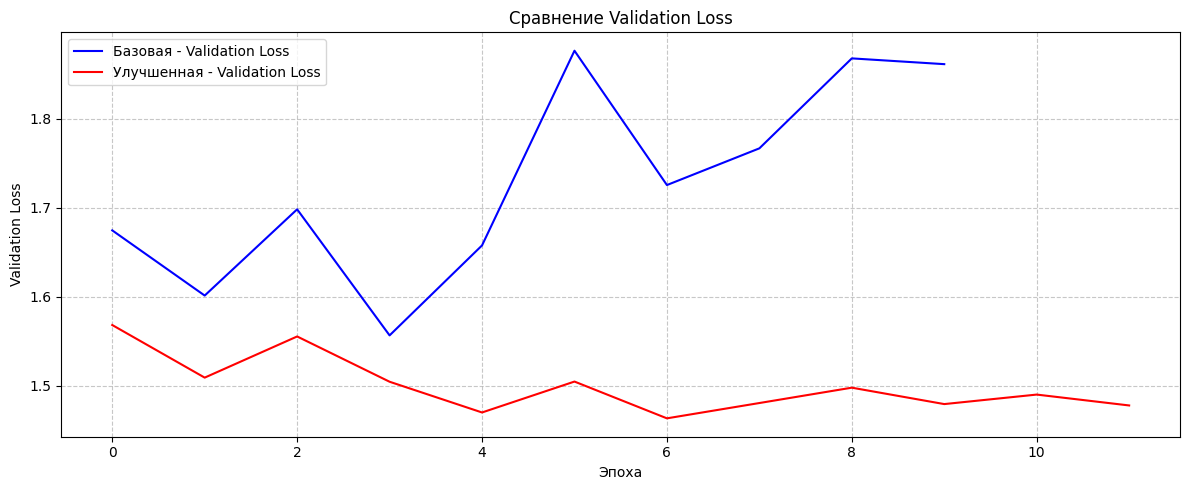

Улучшение по RMSE: 12.13%
Улучшение по MAE: 11.24%


In [85]:
comparison = pd.DataFrame({
    'Модель': ['Базовая', 'Улучшенная'],
    'Test RMSE': [test_rmse_base, test_rmse_improved],
    'Test MAE': [test_mae_base, test_mae_improved],
    'Улучшение RMSE (%)': [0, ((test_rmse_base - test_rmse_improved) / test_rmse_base) * 100],
    'Улучшение MAE (%)': [0, ((test_mae_base - test_mae_improved) / test_mae_base) * 100]
})

print("\nСравнение моделей:")
print(comparison)

plt.figure(figsize=(12, 5))
plt.plot(val_losses_base, 'b-', label='Базовая - Validation Loss')
plt.plot(val_losses_improved, 'r-', label='Улучшенная - Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Validation Loss')
plt.title('Сравнение Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Улучшение по RMSE: {((test_rmse_base - test_rmse_improved) / test_rmse_base) * 100:.2f}%")
print(f"Улучшение по MAE: {((test_mae_base - test_mae_improved) / test_mae_base) * 100:.2f}%")

Благодаря проведённым изменениям модель улучшилась, validation loss заметно ниже в улучшенной модели, чем в базовой. В отличие от базовой модели, где валидационная ошибка начала расти уже после 3-4 эпох,в улучшенной модели валидационная ошибка остается стабильной на протяжении всего обучения. Расхождение между Train и Val Loss не увеличивается значительно

8. Заключение

В ходе лабораторной работы была разработана и оптимизирована рекомендательная счистема на основе метода коллаборативной фильтрации с использованием нейросетевой архитектуры. 

Для того, чтобы сократить число записей с 1 миллиона до предельно допустимого 10 тысяч, при этом сохранив максимум информации, сначала все записи были отфильтрованы по числу взаимодействия больше 5. Затем были отобранные самые активные пользователи, в результате чего было отобрано 9616 записей.

Было достигнуто существенное улучшение качества по сравнению с базовой моделью:
- Снижение RMSE и MAE
- Устранение проблемы переобучения, которая критично проявлялась в базовой модели
- Стабильное качество рекомендаций на протяжении всего процесса обучения

Bias-эмбеддинги позволили модели учитывать индивидуальные особенности пользователей и объектов. Дополнительные скрытые слои и оптимизированная структура сети обеспечили баланс между выразительной способностью и вычислительной эффективностью. Калибровка смещений в forward-проходе значительно улучшила точность предсказаний.

Комбинированная L1 и L2 регуляризации создали более интерпретируемые и устойчивые эмбеддинги. Два уровня dropout (0.3 и 0.2) эффективно предотвратили "запоминание" обучающих данных. Градиентный клиппинг стабилизировал процесс обучения и предотвратил численную нестабильность. Адаптивное управление скоростью обучения через ReduceLROnPlateau позволило точнее находить оптимальные параметры.

Анализ процесса обучения демонстрирует фундаментальное улучшение стабильности улучшенной модели по сравнению с базовой: валидационная ошибка оставалась стабильной на протяжении всего обучения, не наблюдалось типичного для базовой модели расхождения между тренировочной и валидационной ошибками. Это подтверждает, что комплексный подход к оптимизации гиперпараметров и архитектуры модели является критически важным для рекомендательных систем, особенно при работе с ограниченными объемами данных.